<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Factorization-Machine-(FM)" data-toc-modified-id="Factorization-Machine-(FM)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Factorization Machine (FM)</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Implementation" data-toc-modified-id="Implementation-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Implementation</a></span></li></ul></li><li><span><a href="#Reference" data-toc-modified-id="Reference-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Reference</a></span></li></ul></div>

In [1]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12
%watermark -a 'Ethen' -d -t -v -p numpy,pandas,sklearn,matplotlib

Ethen 2018-02-24 09:29:22 

CPython 3.6.3
IPython 6.1.0

numpy 1.14.0
pandas 0.22.0
sklearn 0.19.1
matplotlib 2.1.0


# Factorization Machine (FM)

**Factorization Machine** type algorithms are a combination of linear regression and matrix factorization, the cool idea behind this type of algorithm is it aims model interactions between features (a.k.a attributes, explanatory variables) using factorized parameters. By doing so it has the ability to estimate all interactions between features even with extremely sparse data.

## Introduction

Normally, when we think of linear regression, we would think of the following formula:

\begin{align}
\hat{y}(\textbf{x}) = w_{0} + \sum_{i=1}^{n} w_{i} x_{i}
\end{align}

Where:

- $w_0$ is the bias term, a.k.a intercept.
- $w_i$ are weights corresponding to each feature vector $x_i$, here we assume we have $n$ total features.

This formula's advantage is that it can computed in linear time, $O(n)$. The drawback, however, is that it does not handle feature interactions. To capture interactions, we could introduce a weight for each feature combination. This is sometimes referred to as a $2_{nd}$ ordered polynomial. The resulting model is shown below:

\begin{align}
\hat{y}(\textbf{x}) = w_{0} + \sum_{i=1}^{n} w_{i} x_{i} +  \sum_{i=1}^n \sum_{j=i+1}^n w_{ij} x_{i} x_{j}
\end{align}

Compared to our previous model, this formulation has the advantages that it can capture feature interactions at least for two features at a time. But we have now ended up with a $O(n^2)$ complexity which means that to train the model, we now require a lot more time and memory. Another issue is that when we have categorical variables with high cardinality, after one-hot encoding them, we would end up with a lot of columns that are sparse, making it harder to actually capture their interactions (not enough data).

To solve this complexity issue, Factorization Machines takes inspiration from [matrix factorization](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/recsys/1_ALSWR.ipynb), and models the feature interaction using latent factors. Every feature $f_i$ has a corresponding latent factor $v_i$, and two features' interactions are modelled as $\langle \textbf{v}_i, \textbf{v}_{j} \rangle$, where $\langle \cdot \;,\cdot \rangle$ refers to the dot product of the two feature vector. If we assume its of size $k$ (this is a hyperparameter that we can tune). Then:

\begin{align}
\langle \textbf{v}_i, \textbf{v}_{j} \rangle = \sum_{f=1}^k v_{i,f} v_{j,f}
\end{align}

This leads of our new equation:

\begin{align}
\hat{y}(\textbf{x}) = w_{0} + \sum_{i=1}^{n} w_{i} x_{i} + \sum_{i=1}^{n} \sum_{j=i+1}^n \langle \textbf{v}_i , \textbf{v}_{j} \rangle x_i x_{j}
\end{align}

This is an improvement from our previous model (when we modeled each pair of interaction terms with weight $w_{ij}$) as the number of parameters is reduced from $n^2$ to $n x k$, since $k \ll n$, which also helps mitigate overfitting issues. Using the naive way of formulating factorization machine results in a complexity of $O(kn^2)$, because all pairwise interactions have to be computed, but we can reformulate it to make it run in $O(kn)$.


\begin{align}
\sum_{i=1}^n \sum_{j=i+1}^n \langle \textbf{v}_i, \textbf{v}_{j} \rangle x_{i} x_{j}
&= \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n \langle \textbf{v}_i, \textbf{v}_{j} \rangle x_{i} x_{j} - \frac{1}{2} \sum_{i=1}^n \langle \textbf{v}_i , \textbf{v}_{i} \rangle x_{i} x_{i}  \\
&= \frac{1}{2}\left(\sum_{i=1}^n \sum_{j=1}^n \sum_{f=1}^k v_{i,f} v_{j,f} x_{i} x_{j} \right)\frac{1}{2}\left( \sum_{i=1}^n \sum_{f=1}^k v_{i,f} v_{i,f} x_{i} x_{i} \right) \\
&= \frac{1}{2}\left(\sum_{i=1}^n \sum_{j=1}^n \sum_{f=1}^k v_{i,f} v_{j,f} x_{i} x_{j}  -  \sum_{i=1}^n \sum_{f=1}^k v_{i,f} v_{i,f} x_{i} x_{i} \right) \\
&= \frac{1}{2} \sum_{f=1}^{k} \left( \left(\sum_{i=1}^n v_{i,f}x_{i} \right) \left( \sum_{j=1}^n v_{j,f}x_{j} \right) - \sum_{i=1}^{n} v_{i,f}^2 x_{i}^2 \right) \\
&= \frac{1}{2} \sum_{f=1}^{k} \left( \left( \sum_{i}^{n} v_{i,f}x_{i} \right)^2  - \sum_{i=1}^{n} v_{i,f}^2 x_{i}^2 \right)
\end{align}

Note, summing over different pairs is the same as summing over all pairs minus the self-interactions (divided by two). This is the reason why the value 1/2 is introduced from the beginning of the derivation.

This reformulated equation has a linear complexity in both $k$ and $n$, i.e. its computation is in $O(kn)$, substituting this new equation into the existing factorization machine formula, we end up with:

\begin{align}
\hat{y}(\textbf{x}) = w_{0} + \sum_{i=1}^{n} w_{i} x_{i} + \frac{1}{2} \sum_{f=1}^{k} \left( \left( \sum_{i}^{n} v_{i,f}x_{i} \right)^2  - \sum_{i=1}^{n} v_{i,f}^2 x_{i}^2 \right)
\end{align}

In a machine learning setting, factorization machine can be applied to different supervised prediction tasks:

- **Regression:**, in this case $\hat{y}(\textbf{x})$ can be used directly by minimizing the mean squared error between the model prediction and target value, e.g. $\frac{1}{N}\sum^{N}\big(y - \hat{y}(\textbf{x})\big)^2$
- **Classification:**, if we were to use it in a binary classification setting, we could then minimize the log loss, $\ln \big(1 + exp(-y \cdot \hat{y}(\textbf{x})) \big)$, where $\sigma$ is the sigmoid/logistic function and $y \in {-1, 1}$.

To train factorization machine, we can use a gradient descent based optimization techniques, the parameters to be learned are $(w_0, \mathbf{w},$ and $\mathbf{V}$.

\begin{align}
\frac{\partial}{\partial\theta}\hat{y}(\textbf{x}) =
\begin{cases}
1,  & \text{if $\theta$ is $w_0$} \\
x_i, & \text{if $\theta$ is $w_i$} \\
x_i\sum_{j=1}^{n} v_{j,f}x_j - v_{i,f}x_{i}^2 & \text{if $\theta$ is $v_{i,f}$}
\end{cases}
\end{align}

- Notice that $\sum_{j=1}^n v_{j, f} x_j$ does not depend on $i$, thus it can be computed independently.
- The last formula above, can also be written as $x_i(\sum_{j=1}^{n} v_{j,f}x_j - v_{i,f}x_{i})$.
- In practice, we would throw in some L2 regularization to prevent overfitting.

We'll now wrap up the theoretical section of factorization machine, with some of its advantages:

- We can observe from the model equation that it can be computed in linear time.
- By leveraging ideas from matrix factorization, we can estimate higher order interaction effects even under very sparse data.
- Compared to traditional matrix factorization methods, which is restricted to modeling a user-item matrix, we can leverage other user or item specific features making factorization machine more flexible.

## Implementation

In [8]:
from sklearn.datasets import load_boston

boston_dataset = load_boston()
X = boston_dataset.data
y = boston_dataset.target
colnames = boston_dataset.feature_names

pd.DataFrame(X, columns = colnames).head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


In [9]:
from sklearn.preprocessing import StandardScaler

test_size = 0.1
split_random_state = 1234
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = test_size, random_state = split_random_state)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [10]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor()
rf.fit(X_train_scaled, y_train)
rf.score(X_train_scaled, y_train)

0.9740101355728096

In [11]:
rf.score(X_test_scaled, y_test)

0.8860333902996134

In [14]:
def mean_absolute_percentage_error(y_true, y_pred):
    """
    https://en.wikipedia.org/wiki/Mean_absolute_percentage_error
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

pred = rf.predict(X_test_scaled)
mean_absolute_percentage_error(y_test, pred)

10.378359617504392

In [68]:
from fm import FMRegressor
from lmfm import LMFMRegressor

fm = FMRegressor(learning_rate = 0.1, n_factors = 5)
# fm = LMFMRegressor(n_iter = 30, n_factors=8, verbose=0)
fm.fit(X_train_scaled, y_train)
fm.score(X_train_scaled, y_train)

/Users/mingyuliu/programming/fm/fm.py:61: RuntimeWarning: overflow encountered in multiply
  
/Users/mingyuliu/programming/fm/fm.py:57: RuntimeWarning: invalid value encountered in double_scalars
  term = (v_gradient + 2 * self.reg_v * self.v[factor, feature])


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [65]:
fm.history

[323.2079625263654,
 249.52920974023016,
 202.27259691140958,
 165.95918772936264,
 136.93665594206806,
 113.54927759500728,
 94.66130850818801,
 79.39255320416171,
 67.04163801012541,
 57.04568416943484,
 48.95179526492672,
 42.395071298808865,
 37.08123902965492,
 32.772811306523735,
 29.278013996946104,
 26.441906219227725,
 24.13924800499036,
 22.268764568344867,
 20.748529180163555,
 19.51224341340169,
 18.506238199892444,
 17.687054497078105,
 17.01949045286342,
 16.47502433323274,
 16.03054034072033,
 15.66729873780739,
 15.370103131675208,
 15.126626953668808,
 14.926868535459812,
 14.762710106694877]

In [66]:
fm.score(X_test_scaled, y_test)

0.7607441055597189

In [67]:
pred = fm.predict(X_test_scaled)
mean_absolute_percentage_error(y_test, pred)

16.77656258754585

In [10]:
filepath = 'https://raw.githubusercontent.com/h2oai/app-consumer-loan/master/data/loan.csv'
data = pd.read_csv(filepath)
data = data.dropna(how = 'any')
print('dimension:', data.shape)
data.head(6)

dimension: (157996, 15)


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,purpose,addr_state,dti,delinq_2yrs,revol_util,total_acc,bad_loan,longest_credit_length,verification_status
0,5000,36 months,10.65,10.0,RENT,24000.0,credit_card,AZ,27.65,0.0,83.7,9.0,0,26.0,verified
1,2500,60 months,15.27,0.0,RENT,30000.0,car,GA,1.00,0.0,9.4,4.0,1,12.0,verified
2,2400,36 months,15.96,10.0,RENT,12252.0,small_business,IL,8.72,0.0,98.5,10.0,0,10.0,not verified
3,10000,36 months,13.49,10.0,RENT,49200.0,other,CA,20.00,0.0,21.0,37.0,0,15.0,verified
4,5000,36 months,7.90,3.0,RENT,36000.0,wedding,AZ,11.20,0.0,28.3,12.0,0,7.0,verified
5,3000,36 months,18.64,9.0,RENT,48000.0,car,CA,5.35,0.0,87.5,4.0,0,4.0,verified


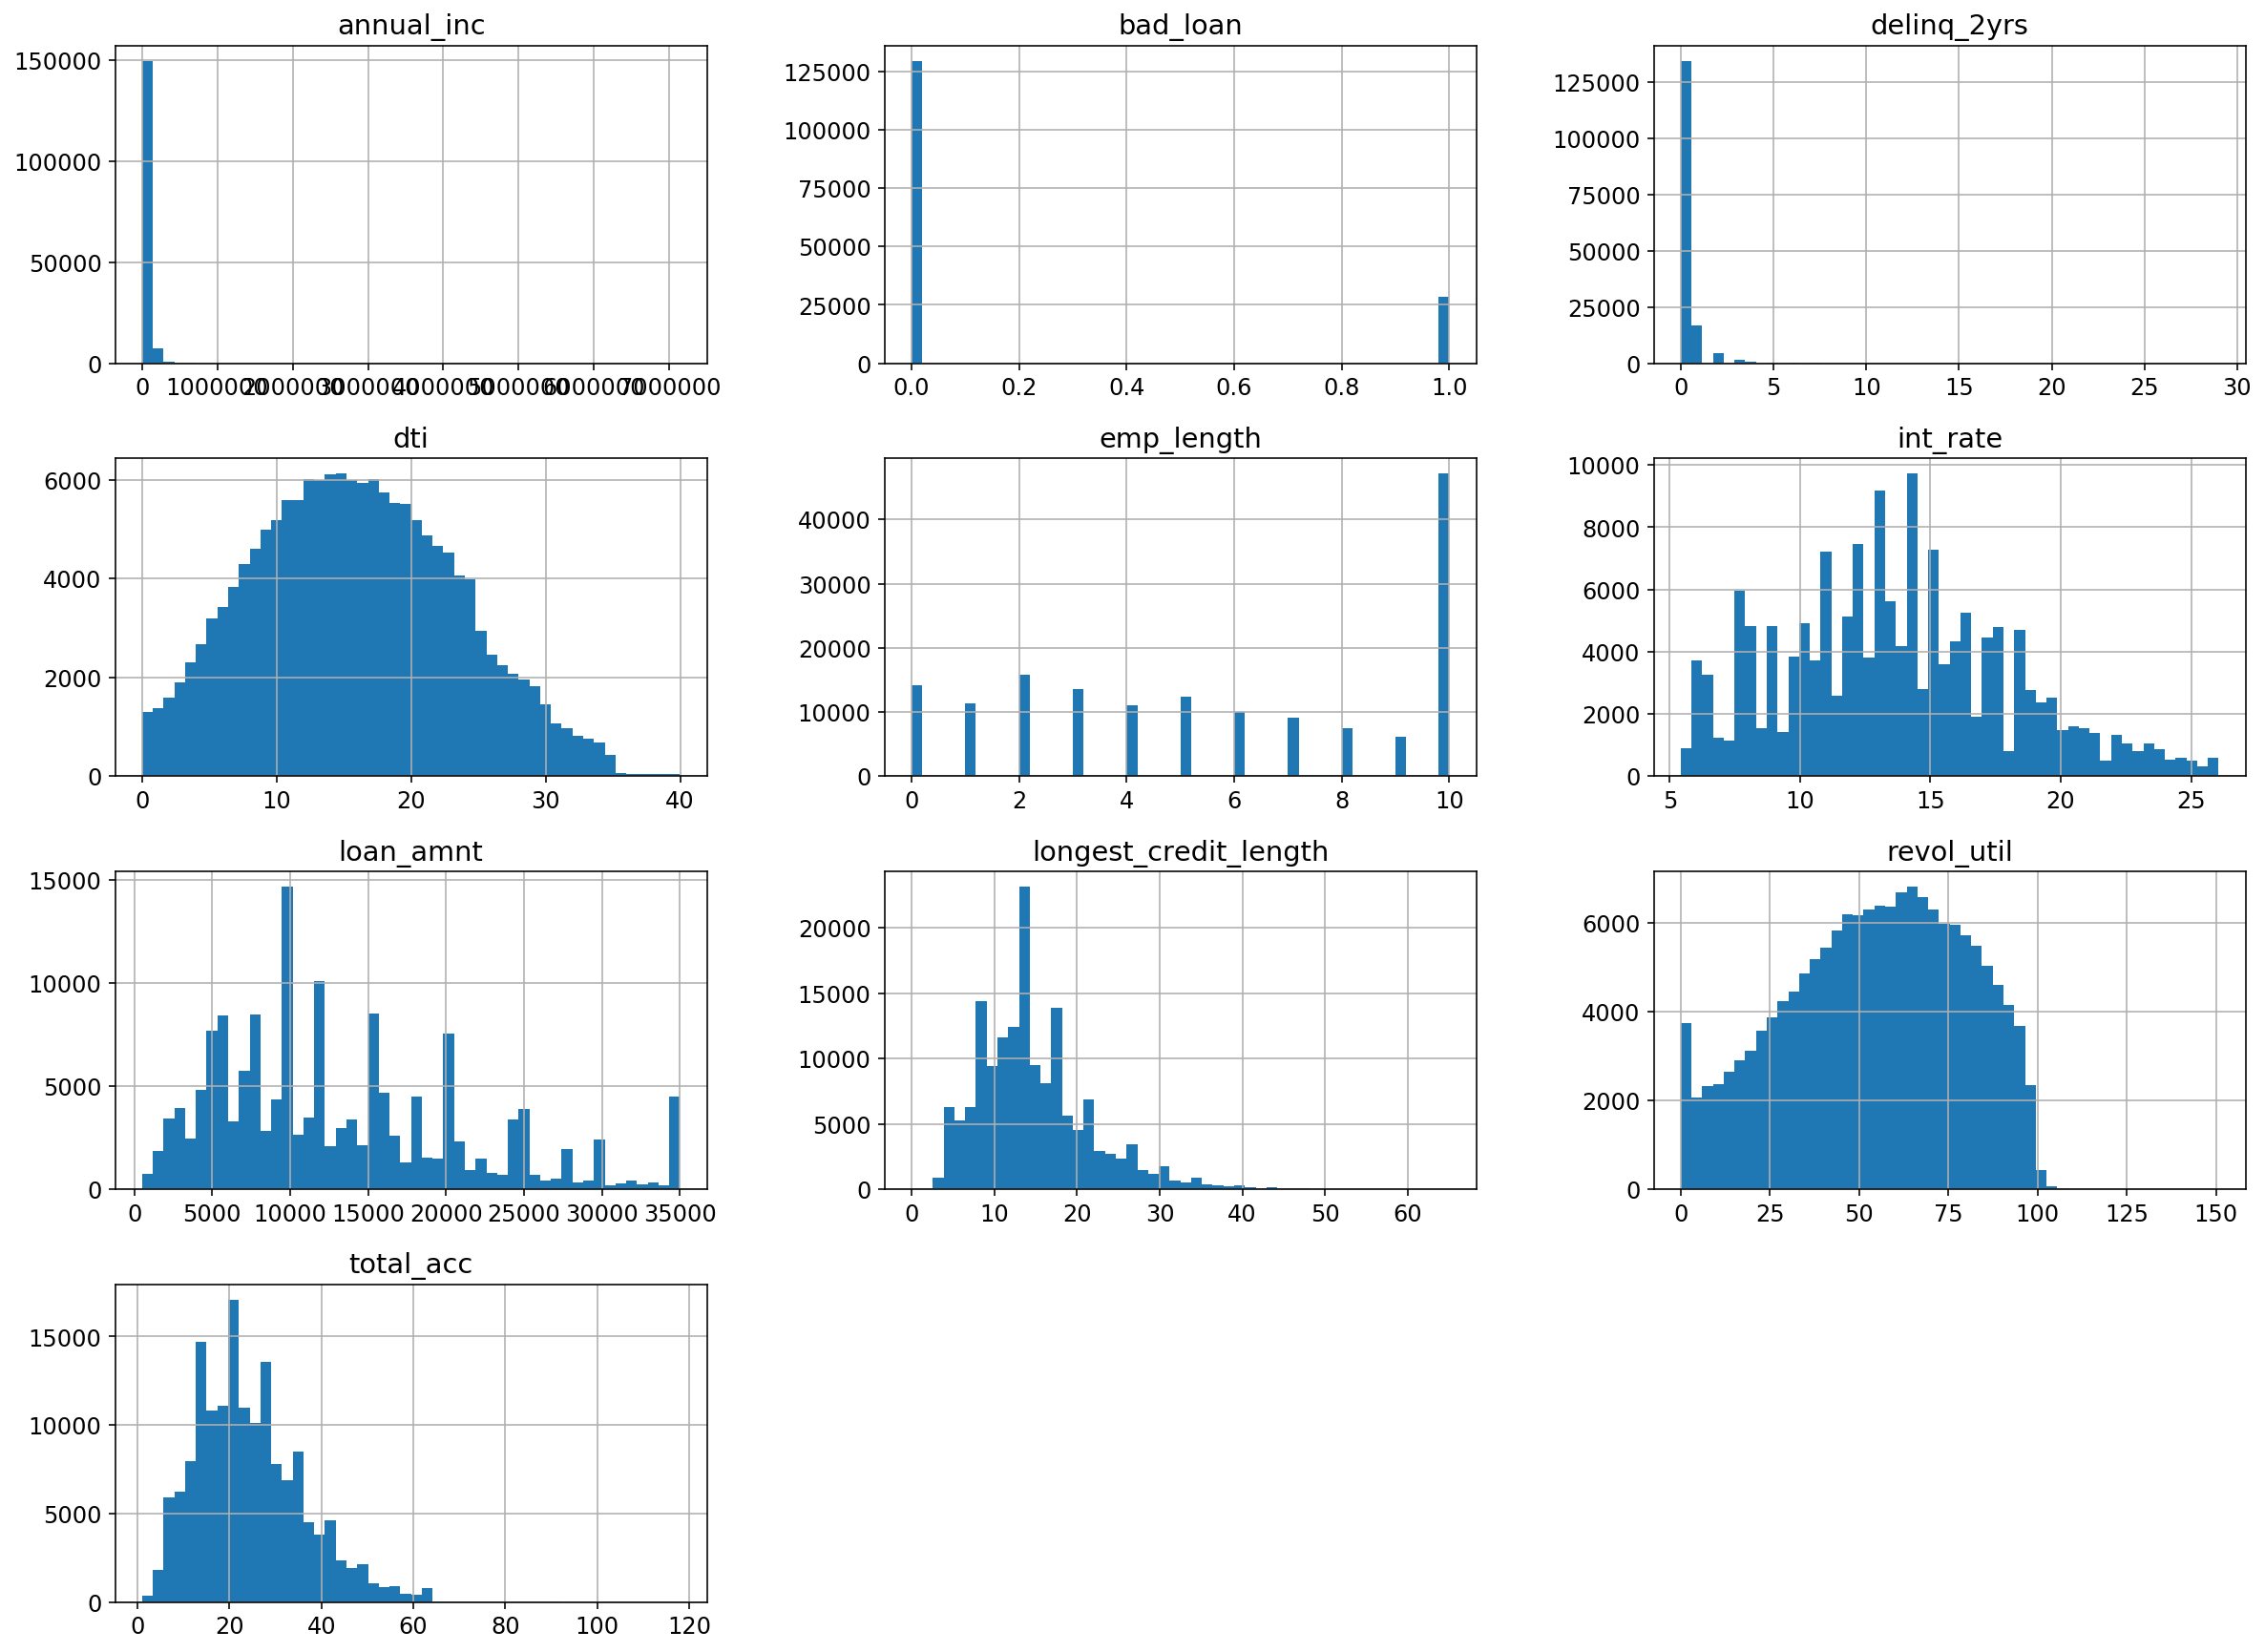

In [11]:
data.hist(bins = 50, figsize = (20, 15))
plt.show()

In [12]:
label_col = 'bad_loan'
num_cols = [
    'loan_amnt', 'int_rate', 'emp_length',
    'annual_inc', 'dti', 'delinq_2yrs',
    'revol_util', 'total_acc', 'longest_credit_length']
cat_cols = [
    'term', 'home_ownership', 'purpose',
    'addr_state', 'verification_status']

In [13]:
# extract target variable, perform
# a quick check of the target variable's skewness
label = data[label_col].values
data = data.drop(label_col, axis = 1)
print('labels distribution:', np.bincount(label) / label.size)

labels distribution: [0.81992582 0.18007418]


In [14]:
# train/validation stratified split
val_size = 0.1
test_size = 0.1
split_random_state = 1234
df_train, df_test, y_train, y_test = train_test_split(
    data, label, test_size = test_size,
    random_state = split_random_state, stratify = label)

df_train, df_val, y_train, y_val = train_test_split(
    df_train, y_train, test_size = val_size,
    random_state = split_random_state, stratify = y_train)

In [15]:
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.pipeline import Pipeline
from mlutils.transformers import Preprocessor
from sklearn.ensemble import RandomForestClassifier


preprocessor = Preprocessor(num_cols = num_cols, cat_cols = cat_cols)
rf = RandomForestClassifier(class_weight = 'balanced', max_depth = 6)
pipeline1 = Pipeline([
    ('preprocess', preprocessor),
    ('rf', rf)
]).fit(df_train, y_train)

In [16]:
pipeline_pred_train = pipeline1.predict_proba(df_train)[:, 1]
pipeline_pred_test = pipeline1.predict_proba(df_test)[:, 1]
roc_auc_score(y_train, pipeline_pred_train)

0.6978463145249801

In [17]:
roc_auc_score(y_test, pipeline_pred_test)

0.681082915784597

In [2]:
import pandas as pd
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# using the example spam dataset
# read it in, extract the input and output columns
sms = pd.read_table('sms.tsv', header = None, names = ['label', 'message'])
sms['label_num'] = sms['label'].map({'ham': 0, 'spam': 1})
X = sms['message']
y = sms['label_num'].values

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

# convert both sets' text column to document-term matrix
vect = TfidfVectorizer()
X_train_dtm = vect.fit_transform(X_train)
X_test_dtm = vect.transform(X_test)

# train the mutinomial naive bayes model, 
# predict on the test set and output the accuracy score
nb = MultinomialNB()
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)
accuracy = metrics.accuracy_score(y_test, y_pred_class)
print('accuracy:', accuracy)

# train the logistic regression model, 
# predict on the test set and output the auc score
logreg = LogisticRegression()
logreg.fit(X_train_dtm, y_train)
y_pred_prob = logreg.predict_proba(X_test_dtm)[:, 1]
auc = metrics.roc_auc_score(y_test, y_pred_prob)
print('auc', auc)

accuracy: 0.964824120603015
auc 0.9949973151959908


In [78]:
y.mean()

0.13406317300789664

In [96]:
from mlutils.models import FMClassifier
from fm import FMDenseClassification
fm = FMClassifier(n_iter = 30, learning_rate = 0.1, lambda_t = 0)
# fm = FMDenseClassification(n_iter = 30, learning_rate = 0.1)
fm.fit(X_train_dtm.A, y_train)

FMDenseClassification(learning_rate=0.1, n_factors=10, n_iter=30,
           random_state=1234, reg_v=0.1, reg_w=0.1)

In [97]:
fm.history

[0.6951996027772894,
 0.6789610276155598,
 0.6655034824021142,
 0.6527754325721137,
 0.6407350754812696,
 0.6293427190048376,
 0.6185607479721436,
 0.6083535763790748,
 0.5986875884360937,
 0.5895310711283251,
 0.580854140599791,
 0.5726286643333699,
 0.564828180786118,
 0.5574278178584597,
 0.5504042113259936,
 0.5437354241435646,
 0.5374008673412766,
 0.531381223069154,
 0.5256583702088138,
 0.5202153128542307,
 0.515036111866974,
 0.5101058196316803,
 0.5054104180727802,
 0.5009367599414636,
 0.49667251334069934,
 0.49260610942410166,
 0.48872669318008516,
 0.485024077194772,
 0.481488698274386,
 0.4781115767994276]

In [98]:
y_pred_class = fm.predict(X_test_dtm.A)
accuracy = metrics.accuracy_score(y_test, y_pred_class)
print('accuracy:', accuracy)

accuracy: 0.8671931083991385


In [99]:
y_pred_prob = fm.predict_proba(X_test_dtm.A)#[:, 1]
auc = metrics.roc_auc_score(y_test, y_pred_prob)
print('auc', auc)

auc 0.6874709146232325


In [33]:
from polylearn import FactorizationMachineClassifier
from lmfm import LMFMClassifier
from mlutils.models import FMClassifier

# fm = FactorizationMachineClassifier(max_iter = 100)
# fm = LMFMClassifier(n_iter = 100)
fm = FMClassifier(n_iter = 30, learning_rate = 0.1, lambda_t = 0)
pipeline2 = Pipeline([
    ('preprocess', preprocessor),
    ('fm', fm)
]).fit(df_train, y_train)

In [34]:
temp = pipeline2.named_steps['fm']
temp.history

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan]

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score
pipeline_pred_train = pipeline2.predict(df_train)#[:, 1]
pipeline_pred_test = pipeline2.predict(df_test)#[:, 1]
accuracy_score(y_train, pipeline_pred_train)

In [ ]:
accuracy_score(y_test, pipeline_pred_test)

In [ ]:
pipeline_pred_train = pipeline2.predict_proba(df_train)#[:, 1]
pipeline_pred_test = pipeline2.predict_proba(df_test)#[:, 1]
roc_auc_score(y_train, pipeline_pred_train)

In [ ]:
roc_auc_score(y_train, pipeline_pred_train)

# Reference

- [Blog: Factorization Machines](http://www.jefkine.com/recsys/2017/03/27/factorization-machines/)
- [Blog: Deep Understanding of FFM Principles and Practices (Chinese)](https://tech.meituan.com/deep-understanding-of-ffm-principles-and-practices.html)
- [Quora: What are the drawbacks of Factorization Machines?](https://www.quora.com/What-are-the-drawbacks-of-Factorization-Machines)
- [Paper: S. Rendle Factorization Machines (2010)](https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf)